# Домашнее задание

Обучите сверточную нейронную сеть на датасете MNIST, взяв любой другой оптимизатор (кроме SGD) и любую другую функцию ошибки (кроме cross-entropy loss). Попробуйте поварьировать параметры: кол-во ядер, `kernel_size` и побить текущий бейзлайн в `0.9746`. Выведите количество обучаемых параметров.    
Какого качества удалось достичь? Попробуйте залоггировать Ваши результаты - построить графики того, как менялись метрики качества (accuracy, loss) с течением эпох, включить логгирование, сравнить результаты между собой при разных параметрах.

Любые дополнительные улучшения (как по методам, так и по коду пайплайна) приветствуются!

*Цель:* выработать навык обучения нейронных сетей (в частности сверточных) на основе средств PyTorch, начиная от загрузки датасетами и заканчивая выводами результатов, их логгированием, сравнением и анализом.

## Preparing

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

In [2]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]
)

In [3]:
mnist_train = torchvision.datasets.MNIST(
    './mnist/',
    train=True,
    download=True,
    transform=transform
)

mnist_val = torchvision.datasets.MNIST(
    './mnist/',
    train=False,
    download=True,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True)

## Baseline

In [4]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон 
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

Определим функцию train(), которая в отличие от примера будет дополнительно принимать необязательный plot. Это добавит возможность выводить получаемые результаты с помощью графика

In [5]:
def train(model, optimizer, n_epochs=5, plot=True):
    val_losses = []
    val_accuracies = []
    for epoch in range(n_epochs):
        
        # обучение
        for x_train, y_train in train_dataloader:
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # валидация
        val_loss = []
        val_accuracy = []
        with torch.no_grad():
            for x_val, y_val in val_dataloader:
                y_pred = model(x_val)
                loss = F.cross_entropy(y_pred, y_val)
                val_loss.append(loss.numpy())
                val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
        val_losses.append(np.mean(val_loss))
        val_accuracies.append(np.mean(val_accuracy))
        
        if plot:
            clear_output(True)
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(val_losses)
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.grid(True)
            plt.subplot(1, 2, 2)
            plt.plot(val_accuracies)
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Accuracy', fontsize=16)
            plt.grid(True)
            plt.show()
            
    print(f"last accuracy: {val_accuracies[-1]}")

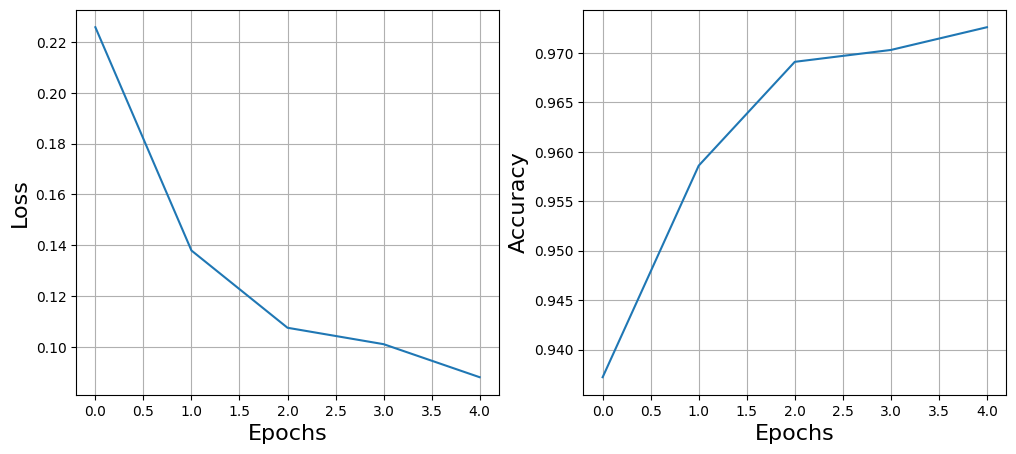

last accuracy: 0.9726


In [6]:
train(model, optimizer)

## Training CNN with F.nll_loss

Определим функцию train(), которая внутри себя использует F.nll_loss()

In [7]:
def train(model, optimizer, n_epochs=5, plot=True):
    val_losses = []
    val_accuracies = []
    for epoch in range(n_epochs):
        
        # обучение
        for x_train, y_train in train_dataloader:
            y_pred = model(x_train)
            loss = F.nll_loss(F.log_softmax(y_pred, dim=1), y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # валидация
        val_loss = []
        val_accuracy = []
        with torch.no_grad():
            for x_val, y_val in val_dataloader:
                y_pred = model(x_val)
                loss = F.nll_loss(F.log_softmax(y_pred, dim=1), y_val)
                val_loss.append(loss.numpy())
                val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
        val_losses.append(np.mean(val_loss))
        val_accuracies.append(np.mean(val_accuracy))
        
        if plot:
            clear_output(True)
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(val_losses)
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.grid(True)
            plt.subplot(1, 2, 2)
            plt.plot(val_accuracies)
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Accuracy', fontsize=16)
            plt.grid(True)
            plt.show()
            
    print(f"accuracy: {val_accuracies[-1]}")

Проверим результат работы новой функции train() с алгоритмом оптимизации Adam и большим числом эпох. Структуру нейронной сети оставим прежней

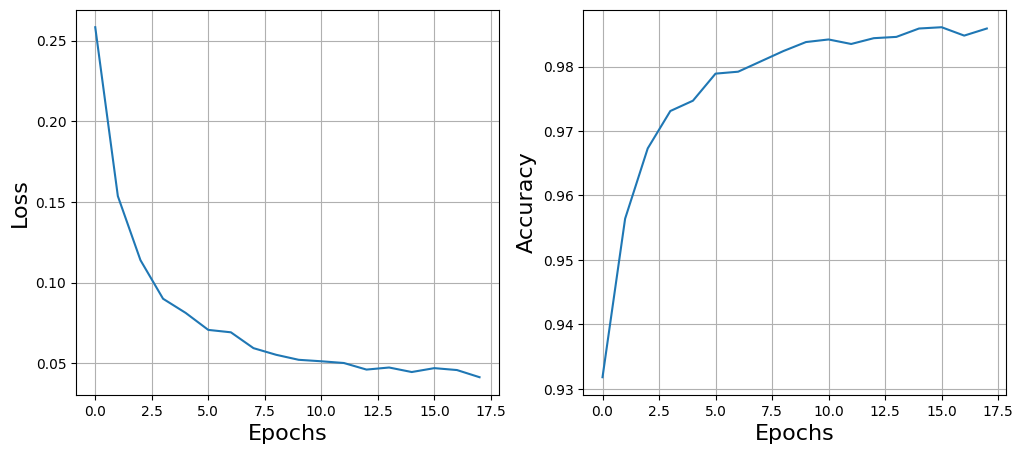

accuracy: 0.9859


In [8]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train(model, optimizer, n_epochs=18)

В целом результат уже выше, чем baseline. Но постараемся его улучшить, меняя структуру нейронной сети

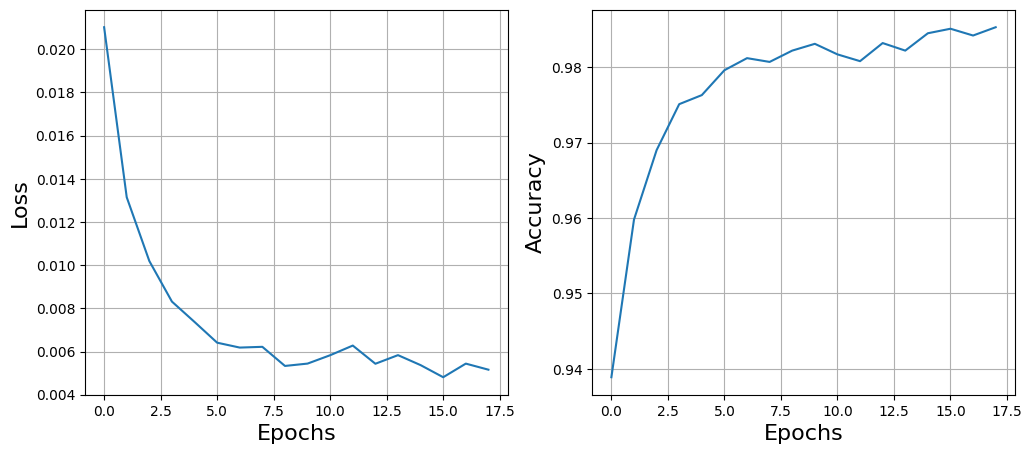

accuracy: 0.9853


In [15]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(13*13*10, 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train(model, optimizer, n_epochs=18)

Попробуем AvgPool2d вместо MaxPool2d

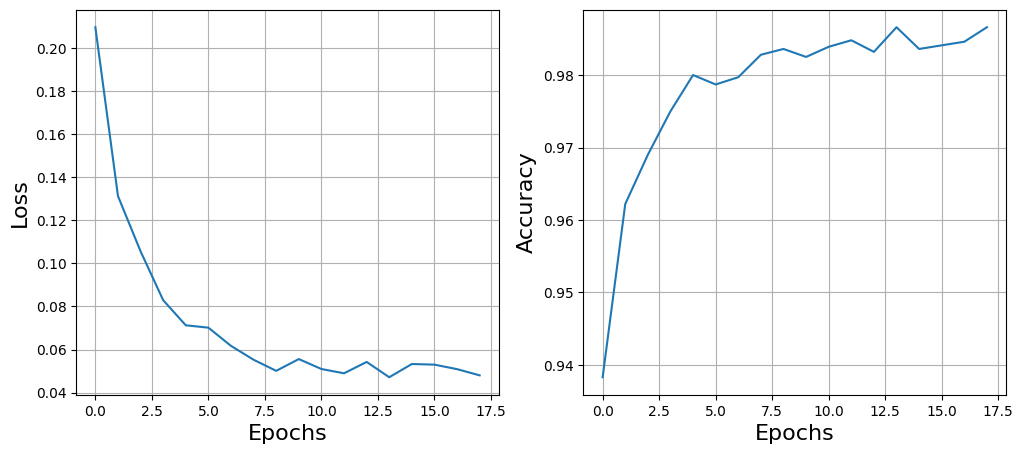

accuracy: 0.9866


In [10]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3),  # grayscale
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(13*13*10, 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train(model, optimizer, n_epochs=18)

Попытаемся использовать параметр stride при свертке изображения

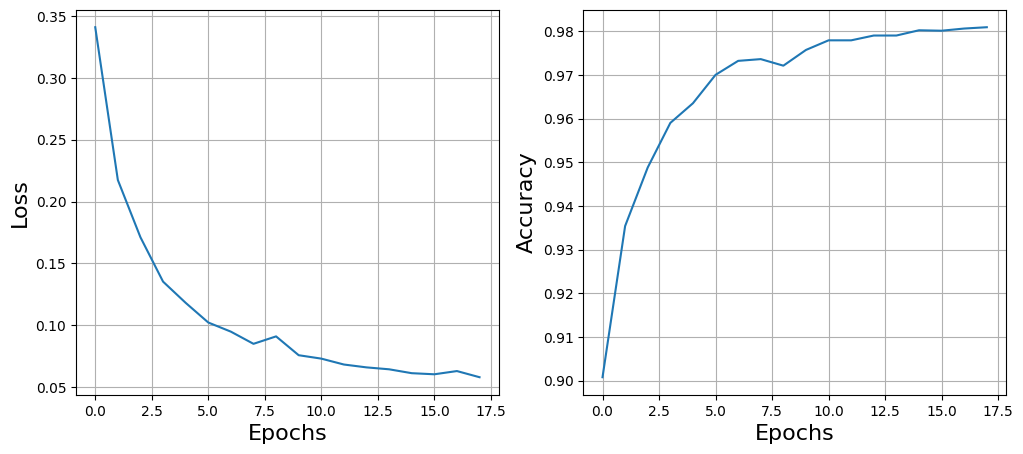

accuracy: 0.9809


In [11]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=4, stride=2),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train(model, optimizer, n_epochs=18)

В нашем случае лучший результат (0.9881) показала нейронная сеть со сверткой 3х3,  Avgpool 2х2 и полносвязными слоями 1690-512-128-64-10

## Training CNN with F.kl_div

Определим функцию train(), которая внутри себя использует F.kl_div()

In [12]:
def train(model, optimizer, n_epochs=5, plot=True):
    val_losses = []
    val_accuracies = []
    for epoch in range(n_epochs):
        
        # обучение
        for x_train, y_train in train_dataloader:
            y_pred = model(x_train)
            
            y_train_probas = torch.zeros((len(y_train), 10))
            y_train_probas[torch.arange(len(y_train)), y_train] = 1.0
            loss = F.kl_div(F.log_softmax(y_pred, dim=1), y_train_probas)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # валидация
        val_loss = []
        val_accuracy = []
        with torch.no_grad():
            for x_val, y_val in val_dataloader:
                y_pred = model(x_val)
                
                y_val_probas = torch.zeros((len(y_val), 10))
                y_val_probas[torch.arange(len(y_val)), y_val] = 1.0
                loss = F.kl_div(F.log_softmax(y_pred, dim=1), y_val_probas)
                
                val_loss.append(loss.numpy())
                val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
        val_losses.append(np.mean(val_loss))
        val_accuracies.append(np.mean(val_accuracy))
        
        if plot:
            clear_output(True)
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(val_losses)
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.grid(True)
            plt.subplot(1, 2, 2)
            plt.plot(val_accuracies)
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Accuracy', fontsize=16)
            plt.grid(True)
            plt.show()
            
    print(f"accuracy: {val_accuracies[-1]}")

Попытаемся найти структуру, при которой качество будет наилучшим.

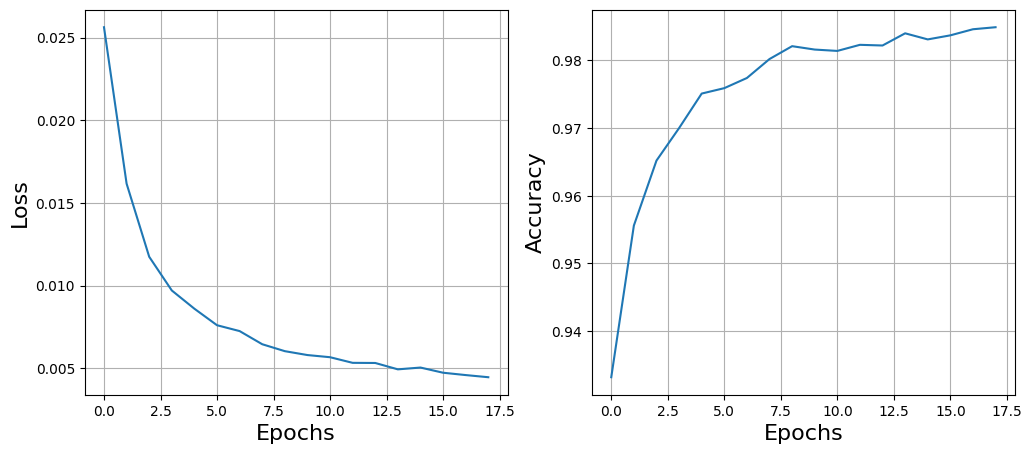

accuracy: 0.9849


In [13]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train(model, optimizer, n_epochs=18)

В случае дивергенции Кульбака-Лейблера, результат для разных моделей оказался ниже, чем для nll-loss

Возьмем модель, которая выдавала наилучший результат, посчитаем, сколько у нее параметров

In [2]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3),  # grayscale
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(13*13*10, 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)

In [8]:
parameters_count = 0

for parameter in model.parameters():
    parameters_count += parameter.flatten().shape[0]
    
print(parameters_count)

940462


## Выводы

Мы попробовали различные структуры нейронных сетей, различные методы пуллинга. Итоговый результат был получен с использованием алгоритма оптимизации Adam, функции ошибки nll-loss, функции активации ReLU и AvgPooling. Структура нейронной сети: свертка 3х3, пулинг 2х2 и 5 полносвязных слоев 1690-512-128-64-10

Количество параметров такой модели равно: 940462